# Práctica 5: Meta aprendizaje
## Dataset: <a src="https://www.kaggle.com/datasets/sooyoungher/smoking-drinking-dataset/">Smoking and Drinking Dataset with body signal</a>

### Contexto

En la practica anterior generamos y analizamos 10 modelos de clasificación, utilizando validación cruzada y calculando su sensibilidad y espesificiadad. Esto con el objetivo de obtener el mejor modelo para clasificar si una persona es bebedora o no. Los 2 mejores modelos fueron los siguientes:

<table>
    <thead>
        <tr>
            <th colspan=4>Sin PCA</th>
        </tr>
        <tr>
            <th>Modelo</th>
            <th>Exactitud</th>
            <th>Sencibilidad</th>
            <th>Especificidad</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td>Neural Net</td>
            <td>72.300000</td>
            <td>72.933333</td>
            <td>71.433333</td>
        </tr>
        <tr>
            <td>Gaussian Process</td>
            <td>72.150000</td>
            <td>71.466667</td>
            <td>72.833333</td>
        </tr>
    </tbody>
</table>

### Importando Librerias

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import f1_score
from numpy import mean
from matplotlib import pyplot as plt
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from mlxtend.classifier import StackingCVClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegression

### Pre-procesado de datos

#### Limpieza

In [2]:
df = pd.read_csv(f'smoking_driking_dataset_Ver01.csv')
df = df.drop_duplicates()
df.loc[:, ["hear_left", "hear_right", "urine_protein", "SMK_stat_type_cd"]] = df[
    ["hear_left", "hear_right", "urine_protein", "SMK_stat_type_cd"]].astype("category")
df["DRK_YN"] = df["DRK_YN"].astype("category")
df["sex"] = df["sex"].astype("category")  
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 991320 entries, 0 to 991345
Data columns (total 24 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   sex               991320 non-null  category
 1   age               991320 non-null  int64   
 2   height            991320 non-null  int64   
 3   weight            991320 non-null  int64   
 4   waistline         991320 non-null  float64 
 5   sight_left        991320 non-null  float64 
 6   sight_right       991320 non-null  float64 
 7   hear_left         991320 non-null  category
 8   hear_right        991320 non-null  category
 9   SBP               991320 non-null  float64 
 10  DBP               991320 non-null  float64 
 11  BLDS              991320 non-null  float64 
 12  tot_chole         991320 non-null  float64 
 13  HDL_chole         991320 non-null  float64 
 14  LDL_chole         991320 non-null  float64 
 15  triglyceride      991320 non-null  float64 
 16  hemoglo

#### Ingenieria de Caracteristicas

In [3]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for col in ["sex","hear_right","hear_left", "DRK_YN"]:
    df.loc[:, [col]] = le.fit_transform(df[[col]])

from sklearn.preprocessing import OrdinalEncoder
ordinal = OrdinalEncoder()
for col in ["urine_protein","SMK_stat_type_cd"]:
    df.loc[:, [col]] = ordinal.fit_transform(df[[col]])

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
for col in ["age","height"]:
    df.loc[:, [col]] = scaler.fit_transform(df[[col]])

from sklearn.preprocessing import OrdinalEncoder
encoder = OrdinalEncoder()
columns_to_encode = ["urine_protein", "SMK_stat_type_cd"]
df[columns_to_encode] = encoder.fit_transform(df[columns_to_encode])

from sklearn.preprocessing import RobustScaler
robust = RobustScaler()
columnas = ['weight', 'waistline', 'sight_left', 'sight_right','SBP', 'DBP', 'BLDS', 'tot_chole', 'HDL_chole', 'LDL_chole', 'triglyceride', 'hemoglobin','serum_creatinine', 'SGOT_AST', 'SGOT_ALT', 'gamma_GTP']
for col in columnas:
    df.loc[:, [col]] = robust.fit_transform(df[[col]])

c:\Users\Antonio\Documents\GitHub\ICD-Portfolio\env\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Antonio\Documents\GitHub\ICD-Portfolio\env\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Antonio\Documents\GitHub\ICD-Portfolio\env\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Antonio\Documents\GitHub\ICD-Portfolio\env\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataC

#### Separando la variable objetivo

In [4]:
df_Y = df.loc[df["DRK_YN"]==1]
df_Y = df_Y[:3000]
df_N = df.loc[df["DRK_YN"]==0]
df_N = df_N[:3000]
dataset = pd.concat([df_Y, df_N],axis=0)
dataset = dataset.sample(frac=1).reset_index(drop=True)
Y = dataset["DRK_YN"]  # Variable objetivo
X = dataset.drop(columns=["DRK_YN"])  # Características

### Definiendo los algoritmos de inferencia

En este apartado definimos cuáles serán nuestros algoritmos de inferencias que serán ensamblados y/o evaluados con StratifiedShuffle. 

In [5]:
clf1 = DecisionTreeClassifier()
clf2 = GaussianNB()
clf3 = KNeighborsClassifier(n_neighbors=3)
clf4 = svm.SVC()
lr = LogisticRegression()

In [6]:
nombres = [
    "Gaussian Process",
    "Neural Net",
    "AdaBoost",
    "Random Forest",
    "Boosting",
    "Bagging",
    "Stacking", 
    "Voting"
]

modelos = [
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(n_estimators=10, random_state=0),
    RandomForestClassifier(n_estimators=10, random_state=0),
    GradientBoostingClassifier(n_estimators=10),
    BaggingClassifier(n_estimators=10),
    StackingCVClassifier(classifiers=[clf1, clf2, clf3, clf4], meta_classifier=lr, random_state=42),
    VotingClassifier(estimators=[('dt', clf1), ('nb', clf2), ('kNN', clf3), ('svm', clf4)],voting='hard')
]

metricas_df = pd.DataFrame(columns=['Modelo', 'Exactitud', 'Sensibilidad', 'Especificidad', 'Experimento'])

sss = StratifiedShuffleSplit(n_splits=10, test_size=0.1, random_state=0)

### Experimento 1

Para nuestro primer experimento utilizaremos la configuración básica, implementando 10 estimadores en los algoritmos de ensamble, exceptuando a Stacking y Voting que cuentan con solamente 4 estimadores.

C:\Users\Antonio\AppData\Local\Temp\ipykernel_12592\1369890196.py:34: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metricas_df = pd.concat([metricas_df, pd.DataFrame(metrics, index=[0])], ignore_index=True)


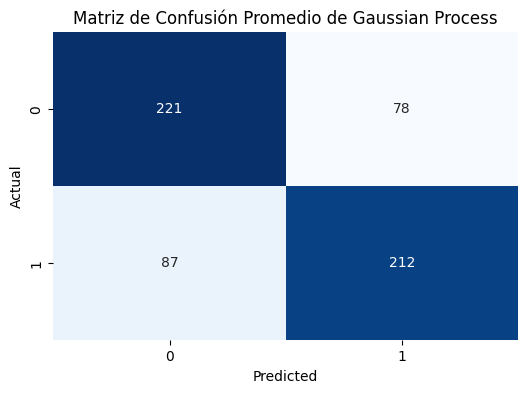

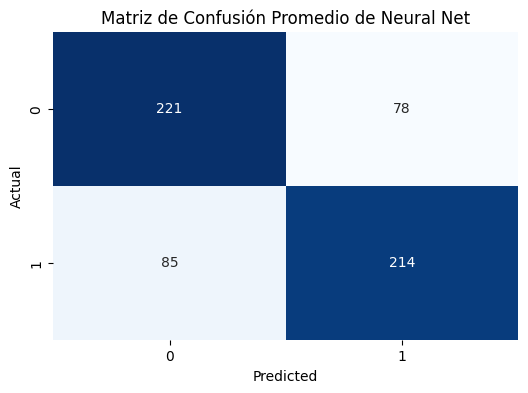

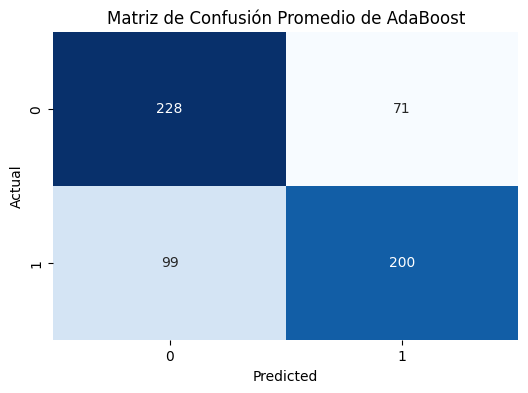

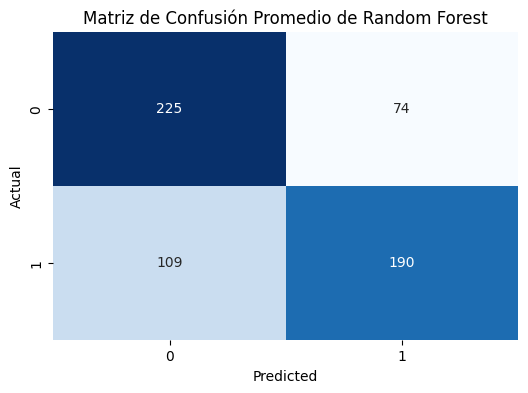

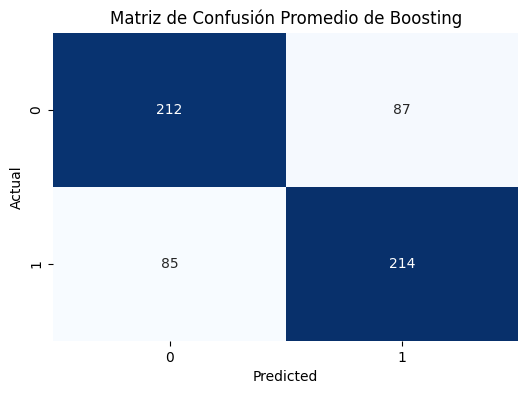

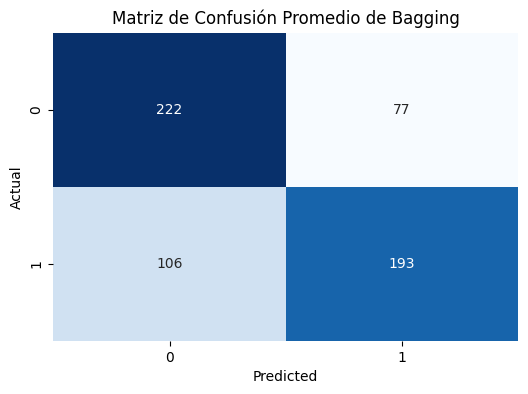

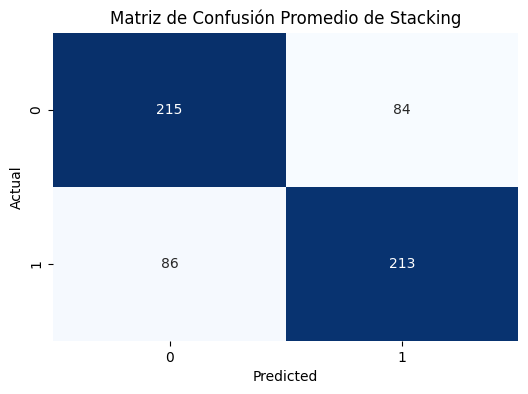

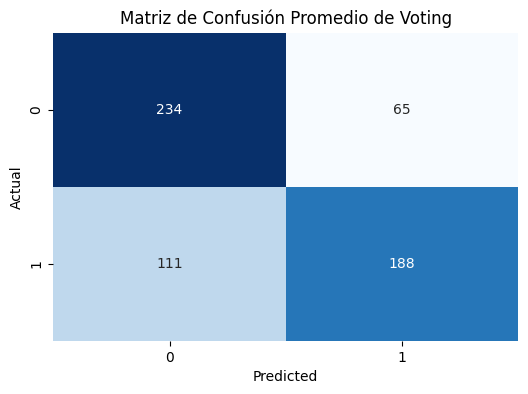

,Modelo,Exactitud,Sensibilidad,Especificidad,Experimento
0,Gaussian Process,72.283333,70.833333,73.733333,1
1,Neural Net,72.633333,71.566667,73.700000,1
2,AdaBoost,71.416667,66.766667,76.066667,1
3,Random Forest,69.233333,63.400000,75.066667,1
4,Boosting,71.133333,71.533333,70.733333,1
5,Bagging,69.400000,64.500000,74.300000,1
6,Stacking,71.566667,71.266667,71.866667,1
7,Voting,70.566667,62.966667,78.166667,1


In [7]:

for nombre, modelo in zip(nombres, modelos):
    scores = []
    sensibilidades = []
    especificidades = []
    matrices_de_confusion = []
    for train_index, test_index in sss.split(X, Y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]
        modelo.fit(X_train, y_train)
        y_pred = modelo.predict(X_test)
        scores.append(accuracy_score(y_test, y_pred))
        conf_matrix = confusion_matrix(y_test, y_pred)
        matrices_de_confusion.append(conf_matrix)
        # Calcular sensibilidad y especificidad
        sensibilidad = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[1, 0])
        especificidad = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
        sensibilidades.append(sensibilidad)
        especificidades.append(especificidad)
    
    matriz_confusion_promedio = sum(matrices_de_confusion) // len(matrices_de_confusion)
    sensibilidad_promedio = mean(sensibilidades)
    especificidad_promedio = mean(especificidades)
    exactitud_promedio = mean(scores)
    
    # Agregar métricas al DataFrame
    metrics = {
        'Modelo': nombre,
        'Exactitud': exactitud_promedio * 100,
        'Sensibilidad': sensibilidad_promedio * 100,
        'Especificidad': especificidad_promedio * 100,
        'Experimento': 1
    }
    
    metricas_df = pd.concat([metricas_df, pd.DataFrame(metrics, index=[0])], ignore_index=True)
    
    average_confusion_np = np.array(matriz_confusion_promedio)
    plt.figure(figsize=(6, 4))
    sns.heatmap(average_confusion_np, annot=True, cmap='Blues', fmt='d', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Matriz de Confusión Promedio de '+nombre)
    plt.show()

metricas_df

#### Conclusión del experimento 1

Podemos observar que con esta configuración inicial los clasificadores tiene un rendimiento de exactitud promedio de entre el 69% y 72%. Donde los algoritmos que no son de ensamble son los que cuentan con un mayor porcentaje de exactitud, sin embargo modelos de ensambles como Random Forest, AdaBoost y Voting cuentan con un mayor porcentaje de especificidad. 

### Experimento 2

Cambios: 
<ul>
    <li>Empatar el número de estimadores con el número de características</li>
    <li>Modificar el random_state</li>
    <li>Neuronal Net con una función de activación ReLu</li>
</ul>

In [8]:
clasifiers_voting = [
    ('dt1', clf1), ('nb1', clf2), ('kNN1', clf3), ('svm1', clf4), 
    ('dt2', clf1), ('nb2', clf2), ('kNN2', clf3), ('svm2', clf4),
    ('dt3', clf1), ('nb3', clf2), ('kNN3', clf3), ('svm3', clf4),
    ('dt4', clf1), ('nb4', clf2), ('kNN4', clf3), ('svm4', clf4),
    ('dt5', clf1), ('nb5', clf2), ('kNN5', clf3), ('svm5', clf4),
    ('dt6', clf1), ('nb6', clf2), ('kNN6', clf3)
]
clasifiers_staking = [
    clf1, clf2, clf3, clf4,
    clf1, clf2, clf3, clf4,
    clf1, clf2, clf3, clf4,
    clf1, clf2, clf3, clf4,
    clf1, clf2, clf3, clf4,
    clf1, clf2, clf3
]
estimatores = 23
randomState = 42
modelos = [
    GaussianProcessClassifier(1.0 * RBF(1.0), random_state=randomState),
    MLPClassifier(alpha=1, max_iter=1000, activation='relu', random_state=randomState),
    AdaBoostClassifier(n_estimators=estimatores, random_state=randomState),
    RandomForestClassifier(n_estimators=estimatores, random_state=randomState),
    GradientBoostingClassifier(n_estimators=estimatores, random_state=randomState),
    BaggingClassifier(n_estimators=estimatores, random_state=randomState),
    StackingCVClassifier(classifiers=clasifiers_staking, meta_classifier=lr, random_state=randomState),
    VotingClassifier(estimators=clasifiers_voting,voting='hard')
]

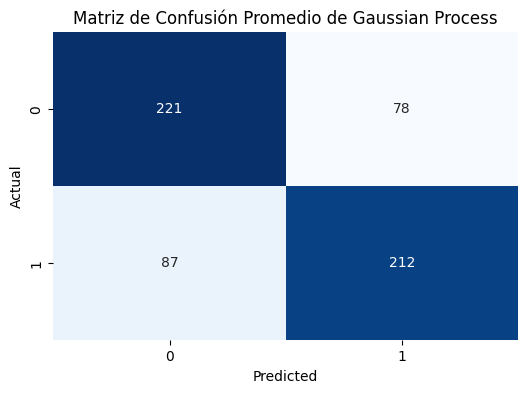

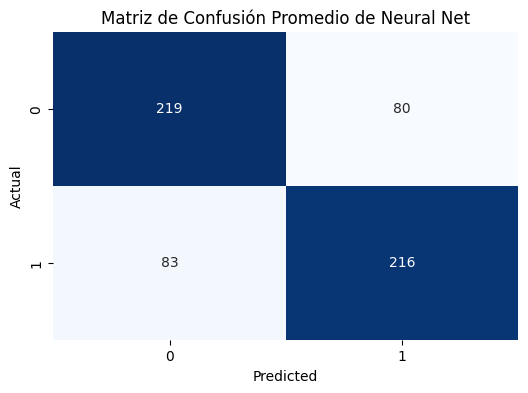

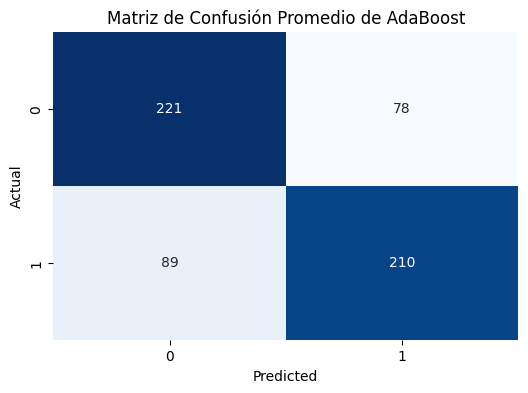

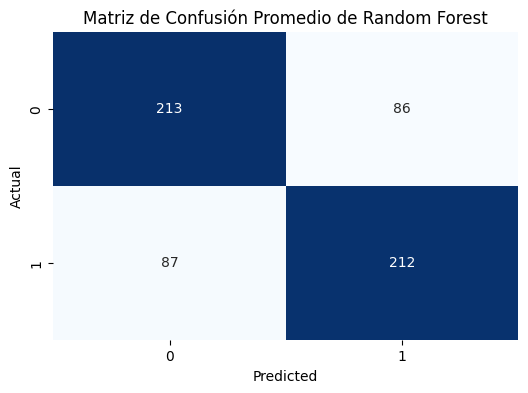

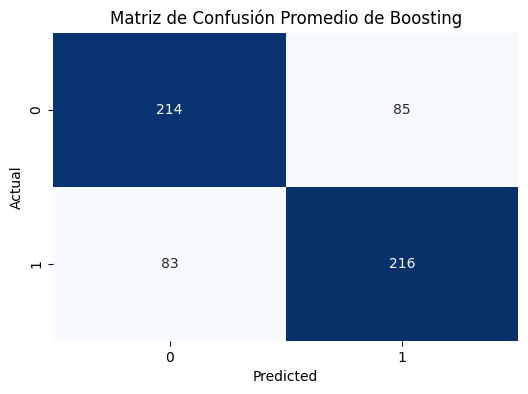

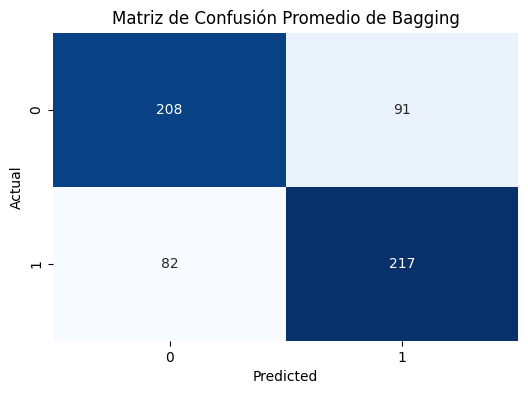

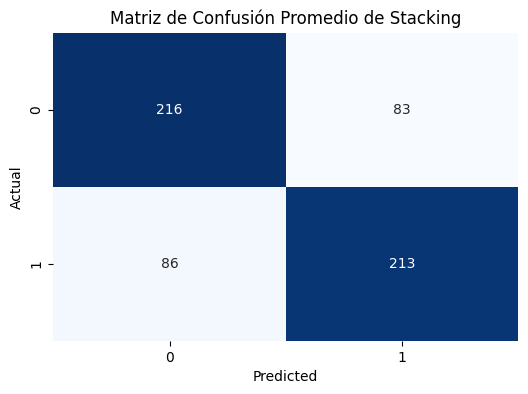

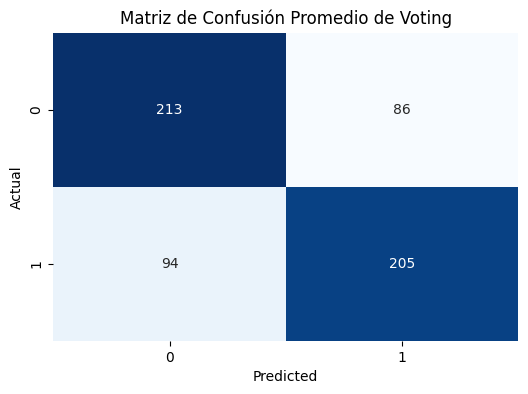

,Modelo,Exactitud,Sensibilidad,Especificidad,Experimento
0,Gaussian Process,72.283333,70.833333,73.733333,1
1,Neural Net,72.633333,71.566667,73.700000,1
2,AdaBoost,71.416667,66.766667,76.066667,1
3,Random Forest,69.233333,63.400000,75.066667,1
4,Boosting,71.133333,71.533333,70.733333,1
5,Bagging,69.400000,64.500000,74.300000,1
6,Stacking,71.566667,71.266667,71.866667,1
7,Voting,70.566667,62.966667,78.166667,1
8,Gaussian Process,72.283333,70.833333,73.733333,2
9,Neural Net,72.650000,72.266667,73.033333,2


In [9]:
for nombre, modelo in zip(nombres, modelos):
    scores = []
    sensibilidades = []
    especificidades = []
    matrices_de_confusion = []
    for train_index, test_index in sss.split(X, Y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]
        modelo.fit(X_train, y_train)
        y_pred = modelo.predict(X_test)
        scores.append(accuracy_score(y_test, y_pred))
        conf_matrix = confusion_matrix(y_test, y_pred)
        matrices_de_confusion.append(conf_matrix)
        # Calcular sensibilidad y especificidad
        sensibilidad = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[1, 0])
        especificidad = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
        sensibilidades.append(sensibilidad)
        especificidades.append(especificidad)
    
    matriz_confusion_promedio = sum(matrices_de_confusion) // len(matrices_de_confusion)
    sensibilidad_promedio = mean(sensibilidades)
    especificidad_promedio = mean(especificidades)
    exactitud_promedio = mean(scores)
    
    # Agregar métricas al DataFrame
    metrics = {
        'Modelo': nombre,
        'Exactitud': exactitud_promedio * 100,
        'Sensibilidad': sensibilidad_promedio * 100,
        'Especificidad': especificidad_promedio * 100,
        'Experimento': 2
    }
    
    metricas_df = pd.concat([metricas_df, pd.DataFrame(metrics, index=[0])], ignore_index=True)
    
    average_confusion_np = np.array(matriz_confusion_promedio)
    plt.figure(figsize=(6, 4))
    sns.heatmap(average_confusion_np, annot=True, cmap='Blues', fmt='d', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Matriz de Confusión Promedio de '+nombre)
    plt.show()

metricas_df

#### Conclusión Experimento 2

Podemos notar que si entre los parámetros todos los modelos cuentan con un random_state del mismo valor, la especificidad se empata entre algunos clasificadores tanto de ensambles como se puede observar en las Filas 8, 9 y 10. Donde los modelos Neural Net, Gaussian Process y AdaBoost tienen un porcentaje muy similar de especificidad.

### Experimento 3

Cambios: 
<ul>
    <li>En Voting y bagging ajustaremos parámetros en los algoritmos de inferencias que se ensamblarán</li>
    <li>Reducir el random_state</li>
    <li>Reducir el número de estimadores</li>
</ul>

In [10]:
clf1 = DecisionTreeClassifier(max_depth=4) #Profundidad maxima de 4 niveles
clf2 = GaussianNB()
clf3 = KNeighborsClassifier(n_neighbors=6) #Duplique el numero de vecinos
clf4 = svm.SVC()
lr = LogisticRegression()

In [11]:
clasifiers_voting = [
    ('dt1', clf1), ('nb1', clf2), ('kNN1', clf3), ('svm1', clf4), 
    ('dt2', clf1), ('nb2', clf2), ('kNN2', clf3), ('svm2', clf4),
    ('dt3', clf1), ('nb3', clf2), ('kNN3', clf3), ('svm3', clf4),
    ('dt4', clf1), ('nb4', clf2), ('kNN4', clf3), ('svm4', clf4),
    ('dt5', clf1), ('nb5', clf2), ('kNN5', clf3), ('svm5', clf4),
    ('dt6', clf1), ('nb6', clf2), ('kNN6', clf3)
]
clasifiers_staking = [
    clf1, clf2, clf3, clf4,
    clf1, clf2, clf3, clf4,
    clf1, clf2, clf3, clf4,
    clf1, clf2, clf3, clf4,
    clf1, clf2, clf3, clf4,
    clf1, clf2, clf3
]
estimatores = 20 #se redujo a 20 estimadores
randomState = 32 # se redujo a 32
modelos = [
    GaussianProcessClassifier(1.0 * RBF(1.0), random_state=randomState),
    MLPClassifier(alpha=1, max_iter=1000, activation='relu', random_state=randomState),
    AdaBoostClassifier(n_estimators=estimatores, random_state=randomState),
    RandomForestClassifier(n_estimators=estimatores, random_state=randomState),
    GradientBoostingClassifier(n_estimators=estimatores, random_state=randomState),
    BaggingClassifier(n_estimators=estimatores, random_state=randomState),
    StackingCVClassifier(classifiers=clasifiers_staking, meta_classifier=lr, random_state=randomState),
    VotingClassifier(estimators=clasifiers_voting,voting='hard')
]

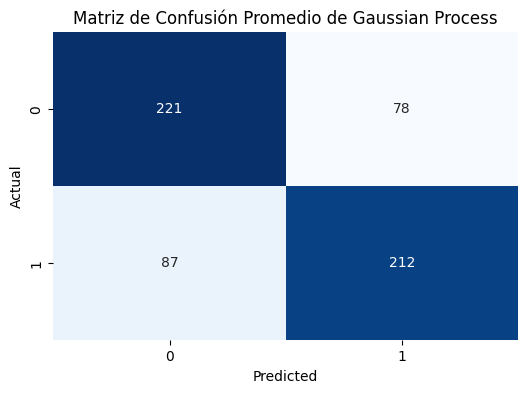

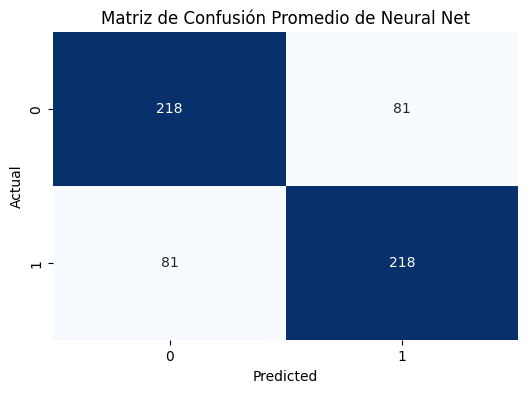

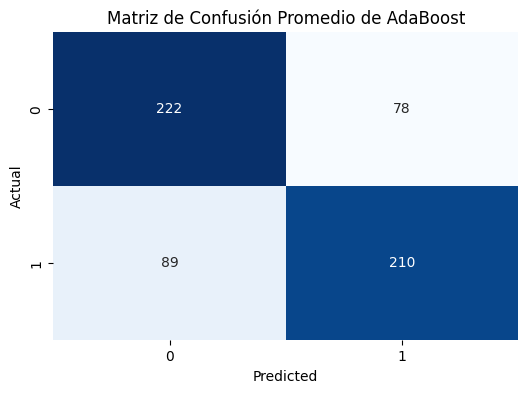

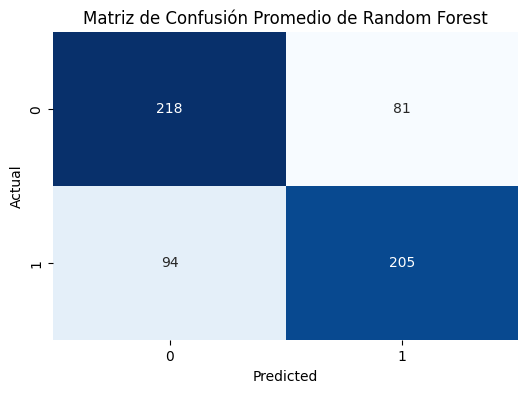

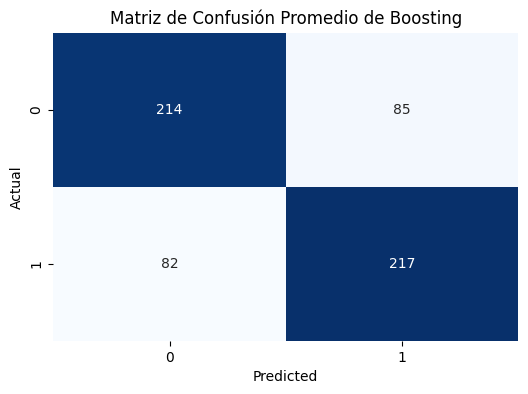

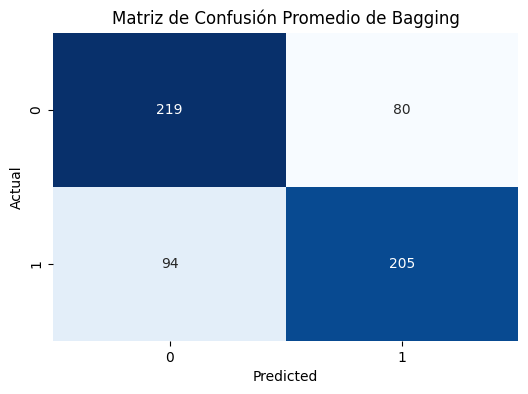

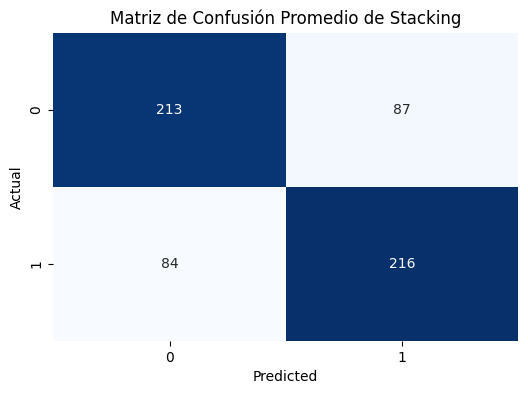

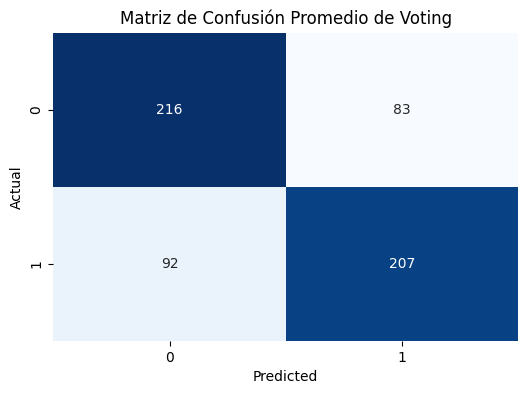

,Modelo,Exactitud,Sensibilidad,Especificidad,Experimento
0,Gaussian Process,72.283333,70.833333,73.733333,1
1,Neural Net,72.633333,71.566667,73.700000,1
2,AdaBoost,71.416667,66.766667,76.066667,1
3,Random Forest,69.233333,63.400000,75.066667,1
4,Boosting,71.133333,71.533333,70.733333,1
5,Bagging,69.400000,64.500000,74.300000,1
6,Stacking,71.566667,71.266667,71.866667,1
7,Voting,70.566667,62.966667,78.166667,1
8,Gaussian Process,72.283333,70.833333,73.733333,2
9,Neural Net,72.650000,72.266667,73.033333,2


In [12]:
for nombre, modelo in zip(nombres, modelos):
    scores = []
    sensibilidades = []
    especificidades = []
    matrices_de_confusion = []
    for train_index, test_index in sss.split(X, Y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]
        modelo.fit(X_train, y_train)
        y_pred = modelo.predict(X_test)
        scores.append(accuracy_score(y_test, y_pred))
        conf_matrix = confusion_matrix(y_test, y_pred)
        matrices_de_confusion.append(conf_matrix)
        # Calcular sensibilidad y especificidad
        sensibilidad = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[1, 0])
        especificidad = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
        sensibilidades.append(sensibilidad)
        especificidades.append(especificidad)
    
    matriz_confusion_promedio = sum(matrices_de_confusion) // len(matrices_de_confusion)
    sensibilidad_promedio = mean(sensibilidades)
    especificidad_promedio = mean(especificidades)
    exactitud_promedio = mean(scores)
    
    # Agregar métricas al DataFrame
    metrics = {
        'Modelo': nombre,
        'Exactitud': exactitud_promedio * 100,
        'Sensibilidad': sensibilidad_promedio * 100,
        'Especificidad': especificidad_promedio * 100,
        'Experimento': 3
    }
    
    metricas_df = pd.concat([metricas_df, pd.DataFrame(metrics, index=[0])], ignore_index=True)
    
    average_confusion_np = np.array(matriz_confusion_promedio)
    plt.figure(figsize=(6, 4))
    sns.heatmap(average_confusion_np, annot=True, cmap='Blues', fmt='d', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Matriz de Confusión Promedio de '+nombre)
    plt.show()

metricas_df

#### Conclusión del Experimento 3

Con los cambios en los parámetros podemos observar que los modelos de Stackin y Voting mejorar 1% más manipulando los parámetros de cada uno los algoritmos que se ensamblan. De ahí en fuera al reducir los estimadores se redujo el rendimiento de todos los modelos.

### Experimento 4

Cambios: 
<ul>
    <li>En Voting y bagging ajustaremos parámetros en los algoritmos de inferencias que se ensamblarán</li>
    <li>Aumentar el random_state</li>
    <li>Aumentar el número de estimadores</li>
</ul>

In [13]:
clf1 = DecisionTreeClassifier(max_depth=8) #Profundidad maxima de 8 niveles
clf2 = GaussianNB()
clf3 = KNeighborsClassifier(n_neighbors=12) #Duplique el numero de vecinos
clf4 = svm.SVC()
lr = LogisticRegression()

In [14]:
clasifiers_voting = [
    ('dt1', clf1), ('nb1', clf2), ('kNN1', clf3), ('svm1', clf4), 
    ('dt2', clf1), ('nb2', clf2), ('kNN2', clf3), ('svm2', clf4),
    ('dt3', clf1), ('nb3', clf2), ('kNN3', clf3), ('svm3', clf4),
    ('dt4', clf1), ('nb4', clf2), ('kNN4', clf3), ('svm4', clf4),
    ('dt5', clf1), ('nb5', clf2), ('kNN5', clf3), ('svm5', clf4),
    ('dt6', clf1), ('nb6', clf2), ('kNN6', clf3)
]
clasifiers_staking = [
    clf1, clf2, clf3, clf4,
    clf1, clf2, clf3, clf4,
    clf1, clf2, clf3, clf4,
    clf1, clf2, clf3, clf4,
    clf1, clf2, clf3, clf4,
    clf1, clf2, clf3
]
estimatores = 30 #se aumento a 30 estimadores
randomState = 50 # se aumento a 50
modelos = [
    GaussianProcessClassifier(1.0 * RBF(1.0), random_state=randomState),
    MLPClassifier(alpha=1, max_iter=1000, activation='relu', random_state=randomState),
    AdaBoostClassifier(n_estimators=estimatores, random_state=randomState),
    RandomForestClassifier(n_estimators=estimatores, random_state=randomState),
    GradientBoostingClassifier(n_estimators=estimatores, random_state=randomState),
    BaggingClassifier(n_estimators=estimatores, random_state=randomState),
    StackingCVClassifier(classifiers=clasifiers_staking, meta_classifier=lr, random_state=randomState),
    VotingClassifier(estimators=clasifiers_voting,voting='hard')
]

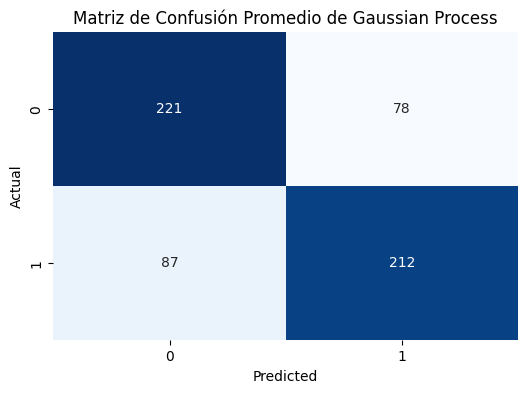

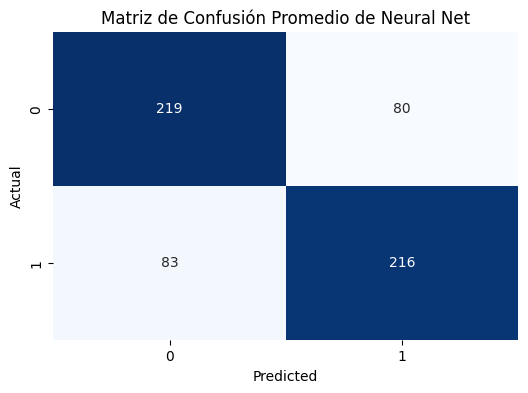

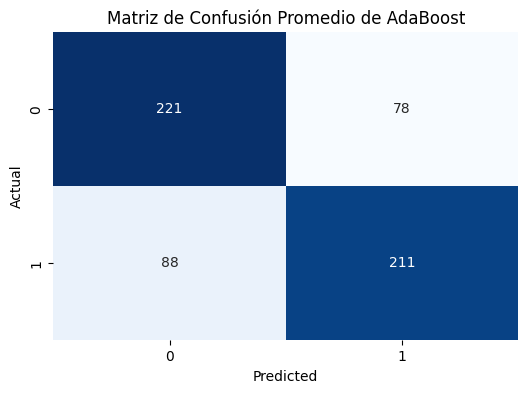

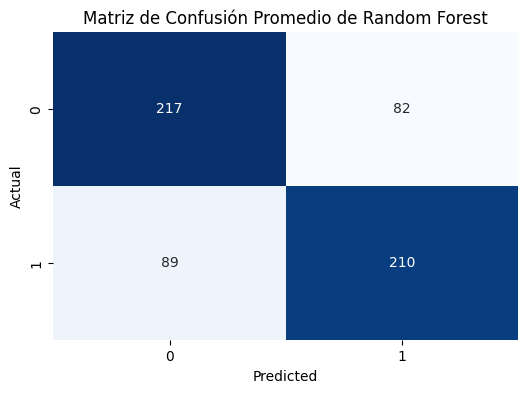

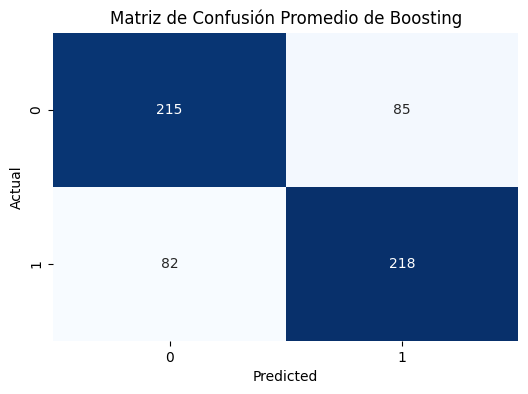

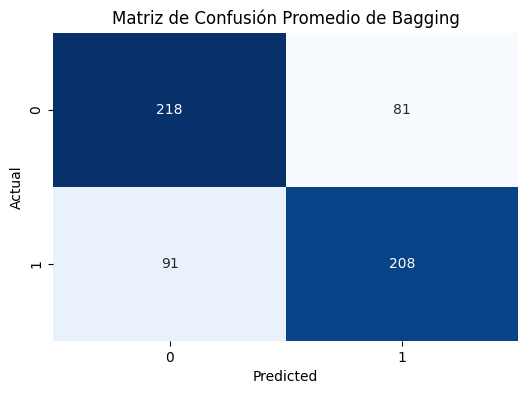

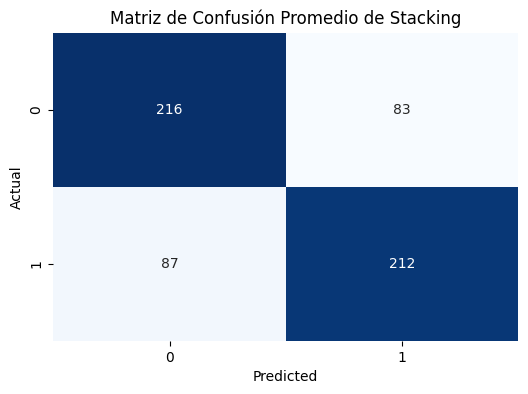

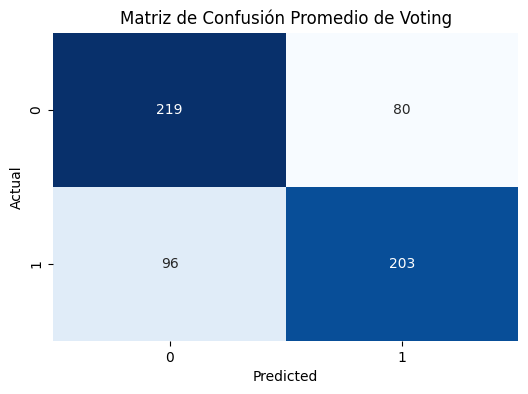

,Modelo,Exactitud,Sensibilidad,Especificidad,Experimento
0,Gaussian Process,72.283333,70.833333,73.733333,1
1,Neural Net,72.633333,71.566667,73.700000,1
2,AdaBoost,71.416667,66.766667,76.066667,1
3,Random Forest,69.233333,63.400000,75.066667,1
4,Boosting,71.133333,71.533333,70.733333,1
5,Bagging,69.400000,64.500000,74.300000,1
6,Stacking,71.566667,71.266667,71.866667,1
7,Voting,70.566667,62.966667,78.166667,1
8,Gaussian Process,72.283333,70.833333,73.733333,2
9,Neural Net,72.650000,72.266667,73.033333,2


In [16]:
for nombre, modelo in zip(nombres, modelos):
    scores = []
    sensibilidades = []
    especificidades = []
    matrices_de_confusion = []
    for train_index, test_index in sss.split(X, Y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]
        modelo.fit(X_train, y_train)
        y_pred = modelo.predict(X_test)
        scores.append(accuracy_score(y_test, y_pred))
        conf_matrix = confusion_matrix(y_test, y_pred)
        matrices_de_confusion.append(conf_matrix)
        # Calcular sensibilidad y especificidad
        sensibilidad = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[1, 0])
        especificidad = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
        sensibilidades.append(sensibilidad)
        especificidades.append(especificidad)
    
    matriz_confusion_promedio = sum(matrices_de_confusion) // len(matrices_de_confusion)
    sensibilidad_promedio = mean(sensibilidades)
    especificidad_promedio = mean(especificidades)
    exactitud_promedio = mean(scores)
    
    # Agregar métricas al DataFrame
    metrics = {
        'Modelo': nombre,
        'Exactitud': exactitud_promedio * 100,
        'Sensibilidad': sensibilidad_promedio * 100,
        'Especificidad': especificidad_promedio * 100,
        'Experimento': 4
    }
    
    metricas_df = pd.concat([metricas_df, pd.DataFrame(metrics, index=[0])], ignore_index=True)
    
    average_confusion_np = np.array(matriz_confusion_promedio)
    plt.figure(figsize=(6, 4))
    sns.heatmap(average_confusion_np, annot=True, cmap='Blues', fmt='d', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Matriz de Confusión Promedio de '+nombre)
    plt.show()

metricas_df

#### Conclusión del Experimento 4

Al aumentar el número de estimadores y el número de random_state, podemos notar que estamos casi en donde iniciamos y solo logramos aumentar décimas de rendimiento.

### Resultados

A continuación se muestran todos los resultados de rendimiento de nuestros modelos.

In [31]:
group = metricas_df.groupby(['Modelo', 'Experimento'])
group.max()

Exactitud  Sensibilidad  Especificidad
Modelo           Experimento                                        
AdaBoost         1            71.416667     66.766667      76.066667
                 2            72.050000     70.200000      73.900000
                 3            72.116667     70.233333      74.000000
                 4            72.200000     70.500000      73.900000
Bagging          1            69.400000     64.500000      74.300000
                 2            70.966667     72.366667      69.566667
                 3            70.783333     68.433333      73.133333
                 4            71.133333     69.433333      72.833333
Boosting         1            71.133333     71.533333      70.733333
                 2            71.883333     72.300000      71.466667
                 3            71.900000     72.366667      71.433333
                 4            72.166667     72.666667      71.666667
Gaussian Process 1            72.283333     70.833333      73.733333
                 2            72.283333     70.833333      73.733333
                 3            72.283333     70.833333      73.733333
                 4            72.283333     70.833333      73.733333
Neural Net       1            72.633333     71.566667      73.700000
                 2            72.650000     72.266667      73.033333
                 3            72.716667     72.733333      72.700000
                 4            72.716667     72.133333      73.300000
Random Forest    1            69.233333     63.400000      75.066667
                 2            70.933333     70.800000      71.066667
                 3            70.600000     68.500000      72.700000
                 4            71.300000     70.066667      72.533333
Stacking         1            71.566667     71.266667      71.866667
                 2            71.716667     71.233333      72.200000
                 3            71.500000     72.000000      71.000000
                 4            71.583333     70.966667      72.200000
Voting           1            70.566667     62.966667      78.166667
                 2            69.783333     68.466667      71.100000
                 3            70.633333     69.233333      72.033333
                 4            70.583333     67.966667      73.200000

A continuación se muestran las mejores configuraciones de todos los algoritmos y el experimento de donde se obtuvo. 
Para evaluar cuáles fueron las mejores configuraciones, se optó por usar un enfoque orientado al promedio de sus resultados de rendimiento.

In [85]:
# Crear un diccionario para almacenar los mejores promedios por modelo
mejoresModelos = {}

for i, k in group:
    for idx, fila in k.iterrows():
        promedio = (fila['Exactitud'] + fila['Sensibilidad'] + fila['Especificidad']) / 3
        modelo = fila['Modelo']

        # Verificar y actualizar el mejor promedio para cada modelo
        if modelo not in mejoresModelos:
            # Si el modelo no está en el diccionario, agregarlo con su primer promedio y número de experimento
            mejoresModelos[modelo] = {'mejorPromedio': promedio, 'experimento': fila['Experimento']}
        else:
            # Si el modelo ya está en el diccionario, comparar y actualizar si el promedio es mejor
            if promedio > mejoresModelos[modelo]['mejorPromedio']:
                mejoresModelos[modelo] = {'mejorPromedio': promedio, 'experimento': fila['Experimento']}

# Generar una lista con los mejores modelos por cada modelo
mejoresModelosFinales = [
    [modelo, info['mejorPromedio'], info['experimento']]
    for modelo, info in mejoresModelos.items()
]

# Imprimir los mejores modelos
mejoresModelosDf = pd.DataFrame(mejoresModelosFinales, columns=["Modelo", "Promedio", "Experimento"])
mejoresModelosDf.sort_values(by=['Promedio'], ascending=False)

,Modelo,Promedio,Experimento
4,Neural Net,72.716667,4
3,Gaussian Process,72.283333,1
0,AdaBoost,72.200000,4
2,Boosting,72.166667,4
6,Stacking,71.716667,2
5,Random Forest,71.300000,4
1,Bagging,71.133333,4
7,Voting,70.633333,3


### Conclusión

Aunque se han obtenido buenos resultados con los modelos de ensamble, el número sigue siendo igual o menor al de los modelos convencionales. Por lo que esto puede deberse a distintos factores mencionados en la práctica pasada. Donde al reducirse el número de instancias puede afectar el resultado de manera significativa. Además de la aparición de muchísimos outliers. 

Sin embargo, al ver los resultados obtenidos en los experimentos, no descarto el uso de redes neuronales profundas para observar su comportamiento con este conjunto de datos.